In [2]:
import matplotlib.pyplot as plt  # Graphics
from matplotlib import colors
import seaborn  # Graphics
import geopandas  # Spatial data manipulation
import pandas  # Tabular data manipulation
import rioxarray  # Surface data manipulation
import xarray  # Surface data manipulation
from pysal.explore import esda  # Exploratory Spatial analytics
from pysal.lib import weights  # Spatial weights
import contextily  # Background tiles

C:\Users\AX\anaconda3\Lib\site-packages\spaghetti\network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [3]:
ref = pandas.read_csv(r'D:\OneDrive - Nexus365\1-Oxford\2 - DPhil project\2024.03.31 Employment and residential centres in Shanghai\2-data\brexit\brexit_vote.csv', 
                      index_col="Area_Code")

lads = geopandas.read_file(
    r'D:\OneDrive - Nexus365\1-Oxford\2 - DPhil project\2024.03.31 Employment and residential centres in Shanghai\2-data\brexit\local_authority_districts.geojson'
).set_index("lad16cd")

db = geopandas.GeoDataFrame(lads.join(ref[["Pct_Leave"]]), crs=lads.crs).to_crs(epsg=3857)[["objectid", "lad16nm", "Pct_Leave", "geometry"]].dropna()

In [8]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = "r"

# 1. Motivating local spatial autocorrelation
To better understand the underpinnings of local spatial autocorrelation, we return to the Moran Plot as a graphical tool.

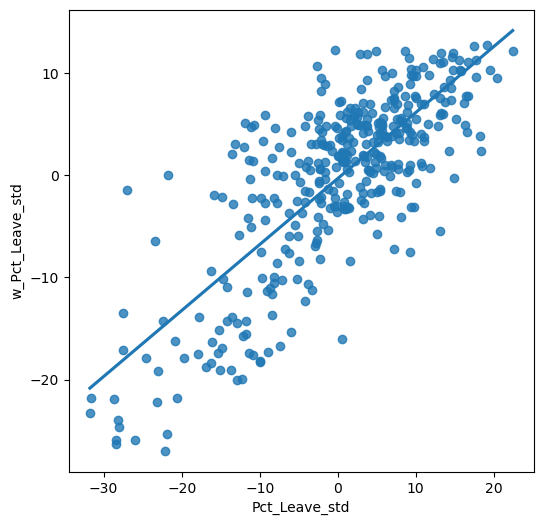

In [9]:
db["w_Pct_Leave"] = weights.lag_spatial(w, db['Pct_Leave'])
db["Pct_Leave_std"] = db["Pct_Leave"] - db["Pct_Leave"].mean()
db["w_Pct_Leave_std"] = weights.lag_spatial(w, db['Pct_Leave_std'])

# Set up the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(
    x="Pct_Leave_std", y="w_Pct_Leave_std", data=db, ci=None
)
plt.show()

Using standardized values, we can immediately divide each variable (percentage that voted to leave, and its spatial lag) in two groups: those with above-average leave voting, which have positive standardized values; and those with below-average leave voting, which feature negative standardized values. 

Applying this thinking to both the percentage to leave and its spatial lag, divides a Moran scatterplot into four quadrants.Each of them captures a situation based on whether a given area displays a value above the mean (high) or below (low) in either the original variable (`Pct_Leave`) or its spatial lag (`w_Pct_Leave_std`).

Using this terminology, we name the four quadrants as follows: high-high (HH) for the top-right, low-high (LH) for the top-left, low-low (LL) for the bottom-left, and high-low (HL) for the bottom right.

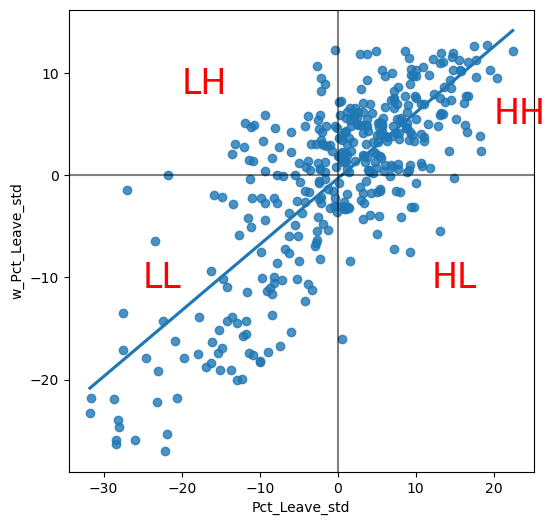

In [10]:
# Set up the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(
    x="Pct_Leave_std", y="w_Pct_Leave_std", data=db, ci=None
)
# Add vertical and horizontal lines
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
plt.text(20, 5, "HH", fontsize=25, c="r")
plt.text(12, -11, "HL", fontsize=25, c="r")
plt.text(-20, 8.0, "LH", fontsize=25, c="r")
plt.text(-25, -11.0, "LL", fontsize=25, c="r")
# Display
plt.show()

# 2. Local Moran's I
Local measures help us to identify areas of *unusual* concentration of values. Clusters will represent values of one type that are *unlikely* to appear under the assumption of spatial randomness. To know whether each location belongs to a *statistically significant* cluster of a given kind, we thus need to compare it with what we would expect if the data were allocated over space in a completely random way. However, what we are interested in is whether the strength with which the values are concentrated is unusually high. This is exactly what LISAs are designed to do.

The core idea of a local Moran's $I_i$ is to **identify cases in which the value of an observation and the average of its surroundings is either more similar (HH or LL) or dissimilar (HL, LH) than we would expect from pure chance**. The mechanism to do this is similar to the one in the global Moran's I, but it is applied in this case to each observation. This results in as many statistics as original observations. The formal representation of the statistic can be written as:

$$
I_i = \dfrac{z_i}{m_2} \displaystyle\sum_j w_{ij} z_j \; ; \; m_2 = \dfrac{\sum_i z_i^2}{n}
$$

where $m_2$ is the second moment (variance) of the distribution of values in the data, $z_i = y_i - \bar{y}$, $w_{i,j}$ is the spatial weight for the pair of observations $i$ and $j$, and $n$ is the number of observations.

In [11]:
lisa = esda.moran.Moran_Local(db["Pct_Leave"], w)

We need to pass the variable of interest—proportion of Leave votes in this context—and the spatial weights that describes the neighborhood relations between the different areas that make up the dataset. This creates a LISA object (`lisa`) that has a number of attributes of interest. The local indicators themselves are in the `Is` attribute and we can get a sense of their distribution using `seaborn`'s kernel density estimate plotting.

<Axes: ylabel='Density'>

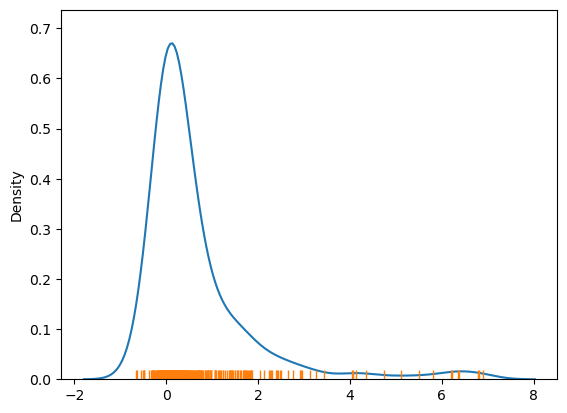

In [13]:
# Draw KDE line
ax = seaborn.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa.Is, ax=ax)

The figure reveals a rather skewed distribution of local Moran's $I_i$ statistics. This outcome is due to the dominance of positive forms of spatial association, implying most of the local statistic values will be positive. Here it is important to keep in mind that the high positive values arise from value similarity in space, and this can be due to either high values being next to high values *or* low values next to low values. **The local $I_i$ values alone cannot distinguish these two cases.**

The figure reveals a rather skewed distribution of local Moran's $I_i$ statistics. This outcome is due to the dominance of positive forms of spatial association, implying most of the local statistic values will be positive. Here it is important to keep in mind that the high positive values arise from value similarity in space, and this can be due to either high values being next to high values *or* low values next to low values. **The local $I_i$ values alone cannot distinguish these two cases.**

we need to bring in additional information that we have computed when calculating the LISA statistics. We do this in four acts. The first one we have already mentioned: a straighforward choropleth of the local statistic of each area. The other three include information on the quadrant each area is assigned into, whether the statistic is considered significant or not, and a combination of those two in a single so-called cluster map. A handy tool in this context is the `splot` library, part of the Pysal family, which provides a lightweight visualization layer for spatial statistics:

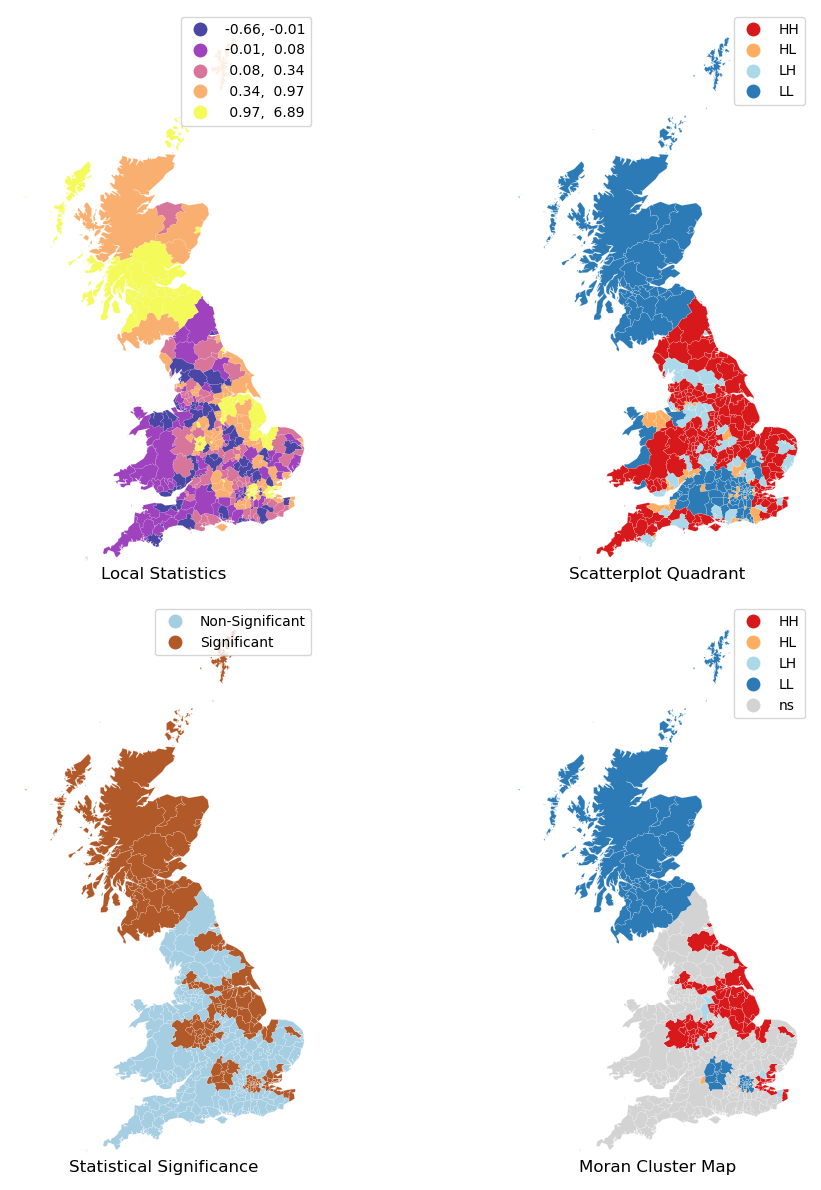

In [15]:
from splot import esda as esdaplot
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
db.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, db, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pandas.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=db.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
db.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, db, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()

The map in the top-right of Figure 5 shows the location of the LISA statistic in the quadrant of the Moran scatterplot. This indicates whether the positive (or negative) local association exists within a specific quadrant, such as the HH quadrant. This information is recorded in the $q$ attribute of the $lisa$ object:
- 1 represents observations in the HH quadrant
- 2 those in the LH one
- 3 in the LL region 
- 4 in the HL quadrant

In [16]:
lisa.q

array([1, 1, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1,
       1, 3, 4, 3, 4, 3, 3, 3, 1, 1, 1, 4, 1, 1, 1, 4, 3, 3, 3, 3, 2, 2,
       1, 1, 1, 1, 2, 3, 1, 1, 2, 3, 3, 3, 2, 3, 4, 1, 3, 3, 3, 3, 2, 1,
       1, 1, 1, 4, 3, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 4, 3, 1, 1, 1, 1, 2, 1,
       1, 1, 4, 1, 1, 1, 1, 3, 2, 3, 4, 4, 3, 3, 4, 3, 3, 3, 3, 2, 1, 1,
       4, 3, 3, 3, 2, 4, 3, 3, 1, 2, 3, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 1, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 2, 2, 3,
       1, 1, 1, 1, 1, 1, 3, 2, 1, 4, 2, 1, 4, 1, 3, 1, 1, 1, 1, 1, 3, 2,
       3, 3, 1, 3, 3, 3, 3, 3, 3, 4, 1, 2, 3, 4, 1, 3, 1, 1, 3, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 4, 1,
       2, 1, 2, 4, 4, 2, 4, 3, 3, 3, 3, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 3,
       1, 4, 2, 1, 2, 2, 2, 3, 1, 1, 1, 1, 2, 2, 3,

To statistical significance, the bottom-left map distinguishes those polygons whose pseudo-$p$-value is above (“*Non-Significant*”) or below (“*Significant*”) the threshold value of 5% we use in this context. An examination of the map suggests that quite a few local authorities have local statistics that are small enough so as to be compatible with pure chance.

# 3. Getis and Ord’s local statistics
Similar to the global case, there are more local indicators of spatial correlation than the local Moran's I. `esda` includes Getis and Ord's $G_i$-type statistics. These are a different kind of local statistic that are commonly used in two forms: 
- the $G_i$ statistic, which omits the value at a site in its local summary 
- the $G_i^*$, which includes the site's own value in the local summary. 

The way to calculate them also follows similar patterns as with the Local Moran's $I_i$ statistics above. Let us see how that would look like for our Brexit example:

In [17]:
# Gi
go_i = esda.getisord.G_Local(db["Pct_Leave"], w)
# Gi*
go_i_star = esda.getisord.G_Local(db["Pct_Leave"], w, star=True)

C:\Users\AX\anaconda3\Lib\site-packages\esda\getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)


Unlike with LISA though, **the $G$ statistics only allow to identify positive spatial autocorrelation**. When standardized, positive values imply clustering of high values, while negative implies grouping of low values. 